The goal of this notebook is to design features that reflect an authors influence and popularity in the subreddit.



## The power law parameter

Based on the exploratory data analysis, the distribution of upvotes conditioned on each author follows (roughly) a power law. We use the estimated parameter of that power law as a measure of the authors popularity. This seems better than using something like the mean post, which will get thrown off by one or two big wins. The median post on the other hand, will get overwhelmed by the huge number of mostly ignored comments.

Note: This is just an feature engineer exploration notebook, this feature needs to be recalculated when doing test train splits. (Well, the same goes for all the other features here.)

In [39]:
import pandas as pd
import seaborn as sns
from scipy.stats import powerlaw

In [68]:
submissions_df = pd.read_csv("../Data/wsb_cleaned.csv")
#comments_df = pd.read_csv("../Data/comments.csv")


In [4]:
submissions_df = submissions_df.loc[submissions_df.author != "None"]

#author_posting = dict(submissions_df.author.value_counts())
#wsb['author_total_upvotes'] = wsb.author.apply( lambda x : author_df.loc[x]['ups'])
#wsb['author_proliferacy'] = wsb.author.apply( lambda x : author_posting[x])


In [20]:
author_df = submissions_df[['author', 'ups']].groupby('author').agg( [lambda x: tuple(x), 'count', 'sum', 'mean'])


In [27]:
author_df = author_df.loc[  author_df[('ups', 'count')] >= 10 ] 

In [48]:
def estimate_power_law_params(data):
    # takes in a list of upvotes, estimtes power low parameters
    # using https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.powerlaw.html
    
    # https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0170920
    # https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777

    return powerlaw.fit(data)
    # returns  a, loc, scale
    

author_df['popularity_parameters'] = author_df[('ups', '<lambda_0>')].apply(estimate_power_law_params)

In [47]:
powerlaw.fit( (-1, 2, 1))

(1.0189544895615934, -1.0175517622292198, 3.0175517872695936)

In [50]:
author_df.sort_values( by = ("ups", "sum"))

ups        \
                                                             <lambda_0> count   
author                                                                          
bikiniyoga            (0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...    22   
old_timerr                               (0, 0, 0, 1, 1, 1, 0, 0, 0, 0)    10   
AcanthisittaNorth698                     (0, 2, 0, 0, 0, 0, 0, 0, 1, 1)    10   
saintharper                              (1, 1, 0, 0, 0, 0, 1, 1, 0, 1)    10   
stockexpertpro                           (0, 0, 0, 0, 1, 1, 1, 1, 0, 1)    10   
...                                                                 ...   ...   
dhiral1994            (23, 1, 1, 1, 1, 1, 1, 9, 471, 54, 1, 38, 197,...   118   
game_stone            (185894, 5, 95801, 71420, 175768, 3, 1409, 1, ...    16   
keenfeed              (341, 1, 224952, 20486, 46653, 463, 761, 72905...    26   
OPINION_IS_UNPOPULAR  (12, 480, 155, 490, 1193, 30, 20, 269, 195, 16...   211   
DeepFuckingValue      (21, 41, 32, 47, 206, 57, 33, 58, 643, 2514, 2...    42   

                                             \
                          sum          mean   
author                                        
bikiniyoga                  3      0.136364   
old_timerr                  3      0.300000   
AcanthisittaNorth698        4      0.400000   
saintharper                 5      0.500000   
stockexpertpro              5      0.500000   
...                       ...           ...   
dhiral1994             517766   4387.847458   
game_stone             743846  46490.375000   
keenfeed              1051350  40436.538462   
OPINION_IS_UNPOPULAR  1267855   6008.791469   
DeepFuckingValue      1669037  39738.976190   

                                                  popularity_parameters  
                                                                         
author                                                                   
bikiniyoga            (0.19468317981292743, -4.7495363560098996e-29,...  
old_timerr            (0.10054328258858355, -4.9098766721589555e-26,...  
AcanthisittaNorth698  (0.3775579714656504, -2.061799335757406e-28, 2...  
saintharper           (1.478787312697507, -0.3194335427303944, 1.319...  
stockexpertpro        (1.478787312697507, -0.3194335427303944, 1.319...  
...                                                                 ...  
dhiral1994            (0.18483573167795658, -2.0678334161622324e-22,...  
game_stone            (0.23852693136973374, -8.01601015067576e-24, 1...  
keenfeed              (0.3559626355853889, 0.9999999999999999, 23392...  
OPINION_IS_UNPOPULAR  (0.34007349167692924, -8.846081558664863e-24, ...  
DeepFuckingValue      (0.30223553849158696, 20.999999999999996, 3000...  

[6163 rows x 5 columns]

In [51]:
# Using the mean of the resulting powerlaw as a numerical proxy
def convert_to_mean( params):
    return powerlaw.moment(1, *params)

author_df['popularity_aggregate'] = author_df['popularity_parameters'].apply(convert_to_mean)

In [71]:
author_df.sort_values(by = 'popularity_aggregate', ascending = False).head(25)

ups        \
                                                             <lambda_0> count   
author                                                                          
DeepFuckingValue      (21, 41, 32, 47, 206, 57, 33, 58, 643, 2514, 2...    42   
keenfeed              (341, 1, 224952, 20486, 46653, 463, 761, 72905...    26   
BootySenpai               (1, 1, 1, 1, 1, 3381, 1, 2, 2, 16, 182058, 2)    12   
ssauronn              (57, 25, 0, 1, 1, 3, 113, 3, 1, 143485, 106, 2...    16   
sugma22               (1, 43, 5590, 1, 9, 1, 1, 3, 146160, 1, 28524,...    13   
Parliament--          (1, 1, 31, 29, 0, 21, 22, 1, 320, 4, 64, 5, 2,...    28   
IDoLikeMyShishkebabs  (1012, 1983, 1301, 743, 3128, 3172, 4770, 3492...    11   
Fargraven               (1, 1, 1, 59, 1, 27, 128246, 1922, 3117, 39428)    10   
sable428              (4, 6, 29, 2, 3, 35, 86715, 1, 2, 1, 1, 1, 1, ...    17   
jacored               (13, 11, 3, 34, 1, 1, 29, 1, 1, 1, 1, 1, 1, 1,...    63   
game_stone            (185894, 5, 95801, 71420, 175768, 3, 1409, 1, ...    16   
hugh_dickinson        (1, 0, 1, 397, 0, 1, 1, 287, 1, 10883, 187, 1,...    23   
MortalDanger00        (12, 50594, 32513, 73692, 99080, 16777, 33, 79...    10   
does-it-mater         (1, 1, 2, 2, 13, 3, 1, 1, 1, 1, 1, 221943, 5, ...    21   
coookiesfoo           (1, 14, 23, 28, 26, 22, 6, 1, 1, 1, 132185, 1,...    15   
lantern_fan           (1, 1, 183, 122, 202, 442, 556, 668, 424, 149,...    20   
No-Bandicoot-8980     (1, 1, 1, 17882, 101309, 6, 29, 15, 5, 2, 1131...    24   
heelhookd             (34, 4, 13, 5, 1, 16, 1, 4, 1, 1, 7, 1, 2, 1, ...    25   
MIA4real              (4413, 6, 6, 1, 24, 53, 14, 5, 5555, 1, 1, 876...    57   
Tsukune_Surprise      (641, 1, 1, 37, 22, 0, 13, 6, 1, 9, 26, 1, 1, ...    36   
psytokine_storm       (9, 152, 20, 17, 1, 1, 1, 3, 75, 91, 22, 127, ...    38   
indonesian_activist   (1, 0, 1, 7, 1, 2, 1, 0, 1, 1, 80, 15, 0, 7, 4...   164   
madmax_br5            (1, 32, 2, 1, 2, 1, 12, 1, 3, 1, 1, 1, 81086, ...    16   
yabou456              (1, 14, 11, 1, 1, 1, 1, 1, 0, 1, 300, 29928, 2...    25   
consygiere            (1, 185, 26403, 1017, 281, 26561, 12702, 242, ...    18   

                                             \
                          sum          mean   
author                                        
DeepFuckingValue      1669037  39738.976190   
keenfeed              1051350  40436.538462   
BootySenpai            185467  15455.583333   
ssauronn               183724  11482.750000   
sugma22                180640  13895.384615   
Parliament--           152479   5445.678571   
IDoLikeMyShishkebabs   237937  21630.636364   
Fargraven              172803  17280.300000   
sable428                86833   5107.823529   
jacored                194682   3090.190476   
game_stone             743846  46490.375000   
hugh_dickinson         111732   4857.913043   
MortalDanger00         273880  27388.000000   
does-it-mater          221983  10570.619048   
coookiesfoo            132679   8845.266667   
lantern_fan            246327  12316.350000   
No-Bandicoot-8980      182953   7623.041667   
heelhookd               92058   3682.320000   
MIA4real               371842   6523.543860   
Tsukune_Surprise       120340   3342.777778   
psytokine_storm         99131   2608.710526   
indonesian_activist    274392   1673.121951   
madmax_br5              81147   5071.687500   
yabou456               117381   4695.240000   
consygiere             248532  13807.333333   

                                                  popularity_parameters  \
                                                                          
author                                                                    
DeepFuckingValue      (0.30223553849158696, 20.999999999999996, 3000...   
keenfeed              (0.3559626355853889, 0.9999999999999999, 23392...   
BootySenpai           (0.4302382415239965, 0.9999999999999999, 18703...   
ssauronn              (0.4628868

In [67]:
author_df.sort_values(by = 'popularity_aggregate', ascending = False).index[:20]

Index(['DeepFuckingValue', 'keenfeed', 'BootySenpai', 'ssauronn', 'sugma22',
       'Parliament--', 'IDoLikeMyShishkebabs', 'Fargraven', 'sable428',
       'jacored', 'game_stone', 'hugh_dickinson', 'MortalDanger00',
       'does-it-mater', 'coookiesfoo', 'lantern_fan', 'No-Bandicoot-8980',
       'heelhookd', 'MIA4real', 'Tsukune_Surprise'],
      dtype='object', name='author')

In [73]:
author_df.to_csv("aggregate_popularity.csv")

In [64]:
merged = submissions_df.merge( author_df.popularity_aggregate, left_on = 'author', right_index = True)

<AxesSubplot:xlabel='popularity_aggregate', ylabel='ups'>

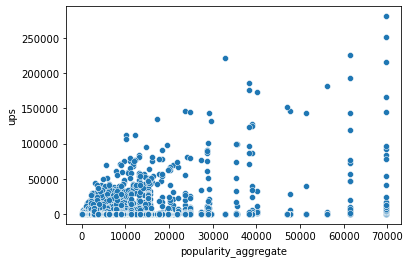

In [74]:

sns.scatterplot( data = merged, x = "popularity_aggregate",y = 'ups')
# of course this is a bit circular, since we are using the upvotes to measure the popularity aggregate score...
# but this at least shows us that the behavior is kind of reasonable... whether or not its better than means or median or max idk...